In [1]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
import matplotlib.pyplot as plt
import json 
import collections
import astropy

In [2]:
snidoutput = Table.from_pandas(pd.read_csv("snid_classes_ZTFI.csv"))

In [3]:
superfit_results = Table.from_pandas(pd.read_csv(r"C:\Users\20xha\Documents\Caltech\Research\superfit\superfit\superfit_classes_ZTFI.csv"))

In [4]:
combined = astropy.table.join(superfit_results, snidoutput, keys = ["Version"])

In [5]:
sample = Table.read("C:/Users/20xha/Documents/Caltech/Research/superfit/ZTFI_data/sample/SEDM_ML_sample.ascii", format = "ascii")
sample.rename_column('col1', 'ZTF_Name')
sample.rename_column('col2', "Class")
sample.rename_column('col3', "redshift")
sample.rename_column('col8', "Version")

In [6]:
final_rcf_table = Table.from_pandas(pd.read_hdf(r"C:\Users\20xha\Documents\Caltech\Research/final_rcf_table.h5"))

In [7]:
sample_2018 = []
counter = 0
for i in sample:
    if("ZTF18" in i["ZTF_Name"]):
        sample_2018.append(counter)
    counter += 1
all_2018 = sample[sample_2018]

In [8]:
negativeII_ztfI = 0
positiveII_ztfI = 0
for i in np.unique(sample["ZTF_Name"]):
    all_version = sample[np.where(sample["ZTF_Name"] == i)]
    name = all_version[0]
    if("II" in name["Class"]):
        positiveII_ztfI += 1
    elif(name["Class"] != "?" and name["Class"] != "-"):
        negativeII_ztfI += 1

In [9]:
negativeII = 0
positiveII = 0
for name in final_rcf_table:
    if("II" in name["sn_type"]):
        positiveII += 1
    else:
        negativeII += 1

In [10]:
negativeII_2018 = 0
positiveII_2018 = 0
for i in np.unique(all_2018["ZTF_Name"]):
    all_version = all_2018[np.where(all_2018["ZTF_Name"] == i)]
    name = all_version[0]
    if("II" in name["Class"]):
        positiveII_2018 += 1
    elif(name["Class"] != "?" and name["Class"] != "-"):
        negativeII_2018 += 1

In [20]:
tp_fp_ratio = []
tp_fp_ratio_rcf = []
tp_fp_ratio_2018 = []
for rlap_num in np.linspace(0,25,46):
    TypeII_Information = Table(
                    names=("ZTF_Name", "spectra_file", "sn_type", "superfit_sn_type", "zooniverse_sn_type", "z_sn", "in_rcfI", "sn_type_rcfI", "in_marshall", "sn_type_marshall"
                    ),
                    meta={"name": "Final ZTF-I Type II Table"},
                    dtype=("U64", "U64", "U64", "U64", "U64", "float32", "bool", "U64", "bool", "U64"
                          )
                    )
    for i in np.unique(combined["ZTF_Name"]):
        data = combined[np.where(combined["ZTF_Name"] == i)]
        index = []
        counter = 0
        for j in data:
            superfitII = "II" in j["Superfit_c"]
            zooniverseII = "II" in j["c_snid_1"]
            if(superfitII and zooniverseII):
                index.append(counter)
            counter += 1
        if(len(index) > 0):
            best = data[index]
            if(len(best) > 1):
                best = best[np.where(best["rlap_1"] == np.max(best["rlap_1"]))]
                if(len(best) > 1):
                    best = best[0]
            if(best["rlap_1"] > rlap_num):
                row = [best["ZTF_Name"], best["Version"], "II", best["Superfit_c"], best["c_snid_1"], best["z_snid"]]
                if(i in final_rcf_table["ZTF_Name"]):
                    rcfI = final_rcf_table["sn_type"][np.where(final_rcf_table["ZTF_Name"] == i)]
                    row.extend([True, rcfI])
                else:
                    row.extend([False, ""])

                if(i in sample["ZTF_Name"]):
                    marshall = sample["Class"][np.where(sample["ZTF_Name"] == i)[0][0]]
                    row.extend([True, marshall])
                else:
                    row.extend([False, ""])
                TypeII_Information.add_row(row)
    counter = 0
    index_counter = 0
    index = []
    for i in TypeII_Information["sn_type_marshall"]:
        if('II' not in i and '-' != i and i != 'NaN'):
            counter += 1
            index.append(index_counter)
        index_counter += 1
    tp_fp_ratio.append([(len(TypeII_Information) - len(index)) / positiveII_ztfI, len(index) / negativeII_ztfI, rlap_num])

    final_rcf_test = TypeII_Information[np.where(TypeII_Information["in_rcfI"] == True)]
    counter = 0
    index_counter = 0
    index = []
    for i in final_rcf_test["sn_type_rcfI"]:
        if('II' not in i):
            counter += 1
            index.append(index_counter)
        index_counter += 1
    tp_fp_ratio_rcf.append([(len(final_rcf_test) - len(index))/ positiveII, len(index)/negativeII, rlap_num])
    
    indicies = []
    temp_counter = 0
    for temp_name in TypeII_Information:
        if("ZTF18" in temp_name["ZTF_Name"]):
            indicies.append(temp_counter)
        temp_counter += 1
    final_2018_test = TypeII_Information[indicies]
    counter = 0
    index_counter = 0
    index = []
    for i in final_2018_test["sn_type_marshall"]:
        if('II' not in i):
            counter += 1
            index.append(index_counter)
        index_counter += 1
    tp_fp_ratio_2018.append([(len(final_2018_test) - len(index))/ positiveII_2018, len(index)/negativeII_2018, rlap_num])

In [21]:
tp_fp_ratio_np = np.asarray(tp_fp_ratio)
tp_fp_ratio_rcf_np = np.asarray(tp_fp_ratio_rcf)
tp_fp_ratio_2018_np = np.asarray(tp_fp_ratio_2018)

Text(0, 0.5, 'True Positive Rate')

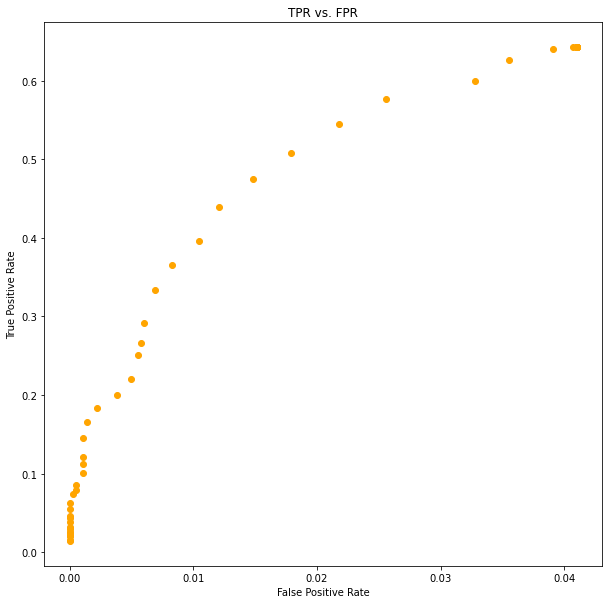

In [22]:
fig = plt.figure(figsize = (10,10))
plt.scatter(tp_fp_ratio_np[:,1], tp_fp_ratio_np[:,0], color = "orange")
plt.title("TPR vs. FPR")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [23]:
tp_fp_ratio_np[np.where(tp_fp_ratio_np[:,0] == np.max(tp_fp_ratio_np[tp_fp_ratio_np[:,1] < 0.016][:,0]))]

array([[0.47457627, 0.01486375, 7.77777778]])

In [24]:
np.save("tf_fp_SNIDxSuperfit", tp_fp_ratio_np)

Text(0, 0.5, 'True Positive Rate')

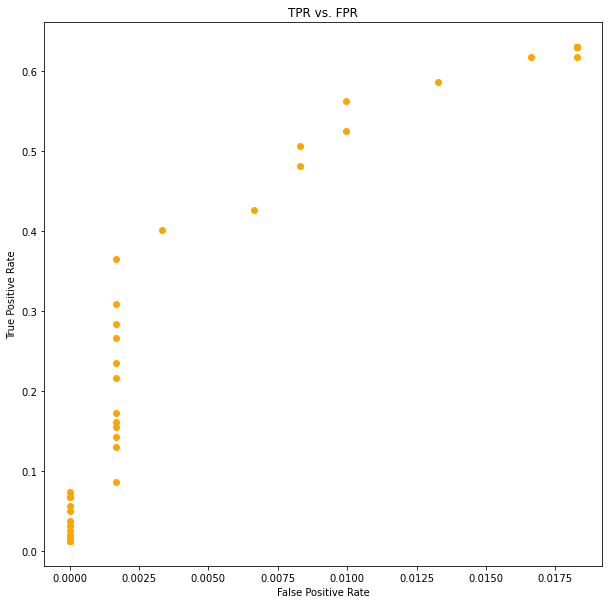

In [25]:
fig = plt.figure(figsize = (10,10))
plt.scatter(tp_fp_ratio_rcf_np[:,1], tp_fp_ratio_rcf_np[:,0], color = "orange")
plt.title("TPR vs. FPR")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [26]:
np.save("tf_fp_rcfI_SNIDxSuperfit", tp_fp_ratio_rcf_np)

Text(0, 0.5, 'True Positive Rate')

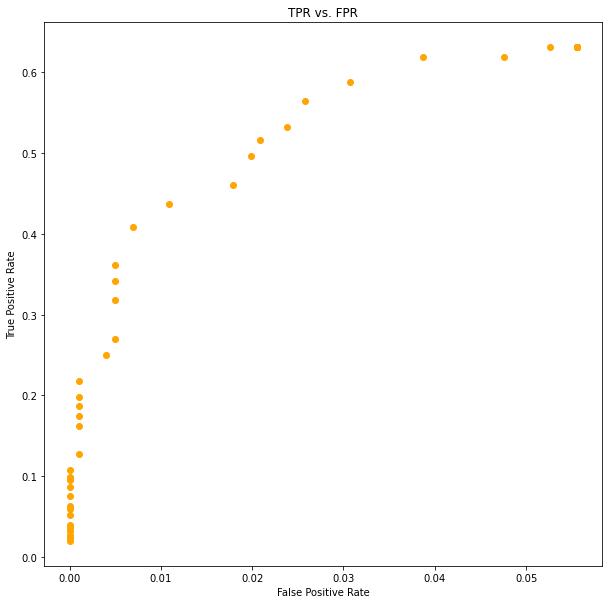

In [27]:
fig = plt.figure(figsize = (10,10))
plt.scatter(tp_fp_ratio_2018_np[:,1], tp_fp_ratio_2018_np[:,0], color = "orange")
plt.title("TPR vs. FPR")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [28]:
np.save("tf_fp_2018_SNIDxSuperfit", tp_fp_ratio_2018_np)